# Full ANN code on New York taxi fare estimation.

This project implements an Artificial Neural Network (ANN) in PyTorch to estimate taxi fares in New York City based on trip details. The model takes both continuous features (e.g., 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count') and categorical features as inputs.

Data preprocessing involved handling categorical variables via embeddings, normalization of continuous features, and splitting into training/validation/test sets. The ANN model was trained using MSE loss and optimized with Adam optimizer, with regularization techniques such as dropout and batch normalization to improve generalization.

Performance was evaluated by measuring prediction error (%) and analyzing how much of the test data lies within specific error bounds (e.g., 10–25% error). The trained model was saved and can be reloaded for inference or further training.

This project demonstrates the effectiveness of ANN in solving a real-world regression problem and showcases model deployment readiness for fare prediction applications.

In [914]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

In [915]:
df = pd.read_csv('Data/NYCTaxiFares.csv')

In [916]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [917]:
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


In [918]:
# Haversine function
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth radius in kilometers
    r = 6371
    return c * r

# Apply to DataFrame
df['distance_travelled'] = haversine(
    df['pickup_longitude'],
    df['pickup_latitude'],
    df['dropoff_longitude'],
    df['dropoff_latitude']
)

In [919]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_travelled
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [920]:
df['distance_travelled'].sort_values()

46019      0.010208
62056      0.010210
9882       0.010250
109630     0.010353
110814     0.010477
            ...    
118513    26.781598
20377     26.911161
108382    26.976530
29074     27.475873
8614      28.846365
Name: distance_travelled, Length: 120000, dtype: float64

### Observation:
As distance is not that great this means all the trips are within the city.

In [921]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [922]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   pickup_datetime     120000 non-null  datetime64[ns, UTC]
 1   fare_amount         120000 non-null  float64            
 2   fare_class          120000 non-null  int64              
 3   pickup_longitude    120000 non-null  float64            
 4   pickup_latitude     120000 non-null  float64            
 5   dropoff_longitude   120000 non-null  float64            
 6   dropoff_latitude    120000 non-null  float64            
 7   passenger_count     120000 non-null  int64              
 8   distance_travelled  120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [923]:
my_time = df['pickup_datetime'][0]

In [924]:
my_time.month

4

In [925]:
df['month'] = df['pickup_datetime'].dt.month

In [926]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_travelled,month
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,4
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,4
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,4
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,4
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,4


In [927]:
df['month'].value_counts()

month
4    120000
Name: count, dtype: int64

### Observation:
Here, we can see that all the records are for the month of April. Therefore, UTC-4 is the timezone. If it was winter then UTC-5 should be implemented.

In [928]:
df['ETD_datetime'] = df['pickup_datetime'] - pd.Timedelta(hours = 4)

In [929]:
df['Hour'] = df['ETD_datetime'].dt.hour

In [930]:
df['AM/PM'] = df['Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

In [931]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_travelled,month,ETD_datetime,Hour,AM/PM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,4,2010-04-19 04:17:56+00:00,4,AM
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,4,2010-04-17 11:43:53+00:00,11,AM
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,4,2010-04-17 07:23:26+00:00,7,AM
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,4,2010-04-11 17:25:03+00:00,17,PM
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,4,2010-04-16 22:19:01+00:00,22,PM


In [932]:
df['Weekday'] = df['ETD_datetime'].dt.strftime("%a")

In [933]:
df['Weekday'].value_counts().sort_values()

Weekday
Sun    13328
Mon    15509
Tue    17189
Wed    17360
Sat    18355
Thu    18539
Fri    19720
Name: count, dtype: int64

In [934]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_travelled', 'month', 'ETD_datetime',
       'Hour', 'AM/PM', 'Weekday'],
      dtype='object')

In [935]:
cat_columns = ['Hour','AM/PM','Weekday']
continuous_columns = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_travelled']

In [936]:
y_col = ['fare_amount']

In [937]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   pickup_datetime     120000 non-null  datetime64[ns, UTC]
 1   fare_amount         120000 non-null  float64            
 2   fare_class          120000 non-null  int64              
 3   pickup_longitude    120000 non-null  float64            
 4   pickup_latitude     120000 non-null  float64            
 5   dropoff_longitude   120000 non-null  float64            
 6   dropoff_latitude    120000 non-null  float64            
 7   passenger_count     120000 non-null  int64              
 8   distance_travelled  120000 non-null  float64            
 9   month               120000 non-null  int32              
 10  ETD_datetime        120000 non-null  datetime64[ns, UTC]
 11  Hour                120000 non-null  int32              
 12  AM/PM           

In [938]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: int32

In [939]:
for cat in cat_columns:
    df[cat] = df[cat].astype('category')

In [940]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

### Observation:
Reason to convert some non-continuous columns to categorical columns:
1. ML models need numerical inputs which can be acheived by one-hot encoding.
2. We can also further converts into label encoding.
3. Improves efficiency.

In [941]:
# Label
df['Weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [942]:
# Building our feature columns
cat_col = torch.tensor(np.stack([df[col].cat.codes for col in cat_columns], axis = 1), dtype = torch.int64)
cont_col = torch.tensor(np.stack([df[cont].values for cont in continuous_columns], axis = 1), dtype = torch.float)

In [943]:
cont_col

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [944]:
# Building the output column
df[y_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fare_amount  120000 non-null  float64
dtypes: float64(1)
memory usage: 937.6 KB


In [945]:
y_col = torch.tensor(np.array(df[y_col]), dtype = torch.float).reshape(-1,1)

In [946]:
y_col

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [947]:
cat_sizes = [len(df[col].cat.categories) for col in cat_columns]

In [948]:
cat_sizes

[24, 2, 7]

"Now, here we can do one-hot encoding for the categorical values, but it will unnecessarily increase the size of the data and memory. Instead, we can use embeddings, which are a better option because they create dense, low-dimensional representations that:
* reduce memory and computational cost,
* avoid sparsity,
* and capture similarity between categories, improving model performance."

In [949]:
# To decide the size of the embedding for each categorical columns
emb_sizes = [(size,min(24,(size+1)//2)) for size in cat_sizes]

In [950]:
emb_sizes

[(24, 12), (2, 1), (7, 4)]

This means first categorical column will be represented by combination of 12 different float numbers. Similarly second and third column.

In [951]:
# Embedding
# Here ni = no_of_unique_category_values & nf = size_of_embedding
# nn.ModuleList will wrap the list comprehension so that pytorch will knows they are a part of the model.

selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_sizes])
embeddings = []
for i,e in enumerate(selfembeds):
    embeddings.append(e(cat_col[:,i]))

new_cat_col = torch.cat(embeddings,1)

In [952]:
new_cat_col

tensor([[-0.9024,  0.0653, -1.5642,  ..., -0.7976,  1.6896, -0.5356],
        [ 1.4254,  1.2905, -0.8445,  ..., -1.3249, -0.0623,  1.4688],
        [ 1.1348, -0.9523, -0.9763,  ..., -1.3249, -0.0623,  1.4688],
        ...,
        [-0.0105, -0.5978,  1.3311,  ..., -1.1332, -0.1510,  0.7660],
        [-0.9024,  0.0653, -1.5642,  ...,  0.1939, -0.8683, -0.2260],
        [ 1.0016, -0.3260,  1.1799,  ..., -1.3249, -0.0623,  1.4688]],
       grad_fn=<CatBackward0>)

#### Now, in order to reduce the size and increase the computational efficiency we drop the values which are having a lesser probability to occur.

In [953]:
# Droping the values which are having p < 0.4 
# Meaning: during training, 40% of the neurons in the input will be randomly set to 0 to prevent overfitting.
selfembdrop = nn.Dropout(0.4)
new_cat_col = selfembdrop(new_cat_col)

## By using similar approach let's design the ANN structure

In [954]:
class Model(nn.Module):
    # Here layers is a list consisting of no of neurons at different layers. y_out = number of nodes at output layer.
    def __init__(self,n_cont,emb_sizes,layers,y_out,p): 
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont) # Normalizing the continuous features.
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_sizes))
        n_in = n_emb + n_cont # n_in = total Number of inputs
        
        # Creating ANN structure
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],y_out))
        self.layers = nn.Sequential(*layerlist)

    def forward(self,x_cat,x_cont):
        embeddings = []
        for i,e in enumerate(selfembeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        
        # Applying the layer object to data
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        
        # Combining the continuous and categorical data
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x
    

In [955]:
torch.manual_seed(33)
model = Model(cont_col.shape[1], emb_sizes, [200,100], 1, p=0.4)

In [956]:
model

Model(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [957]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train-test split
Total records are large in number. So, we are diving it into batches of 60000

In [958]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cat_col[:batch_size-test_size]
cat_test = cat_col[batch_size-test_size:batch_size]
cont_train = cont_col[:batch_size-test_size]
cont_test = cont_col[batch_size-test_size:batch_size]
y_train = y_col[:batch_size-test_size]
y_test = y_col[batch_size-test_size:batch_size]

In [959]:
len(cat_train)

48000

In [960]:
epoch = 350
losses = []
for i in range(1,epoch+1):
    y_pred = model(cat_train, cont_train)
    y_pred
    loss = torch.sqrt(criterion(y_pred , y_train))
    losses.append(loss)
    if i%10 == 1:
        print(f'epoch : {i} & loss = {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch : 1 & loss = 12.583398818969727
epoch : 11 & loss = 11.696243286132812
epoch : 21 & loss = 11.1165132522583
epoch : 31 & loss = 10.7376708984375
epoch : 41 & loss = 10.453975677490234
epoch : 51 & loss = 10.226544380187988
epoch : 61 & loss = 10.039261817932129
epoch : 71 & loss = 9.839247703552246
epoch : 81 & loss = 9.641098976135254
epoch : 91 & loss = 9.434945106506348
epoch : 101 & loss = 9.180952072143555
epoch : 111 & loss = 8.921332359313965
epoch : 121 & loss = 8.586803436279297
epoch : 131 & loss = 8.21924114227295
epoch : 141 & loss = 7.8382368087768555
epoch : 151 & loss = 7.424097537994385
epoch : 161 & loss = 6.946298599243164
epoch : 171 & loss = 6.471675872802734
epoch : 181 & loss = 5.97716760635376
epoch : 191 & loss = 5.486839294433594
epoch : 201 & loss = 5.057824611663818
epoch : 211 & loss = 4.620018482208252
epoch : 221 & loss = 4.302813529968262
epoch : 231 & loss = 4.109052658081055
epoch : 241 & loss = 3.9725093841552734
epoch : 251 & loss = 3.8808121681

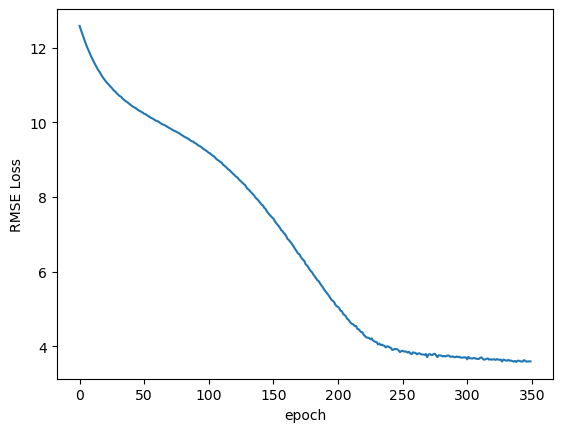

In [961]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epoch), [losses[i].detach().numpy() for i in range(len(losses))])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');


## Let's Validate the model

In [962]:
# TO EVALUATE THE ENTIRE TEST SET

# To not change the weights and biases of our model we use torch.no_grad()
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.56157947


Let's see if there is any outliers as compared to the most of the error values.

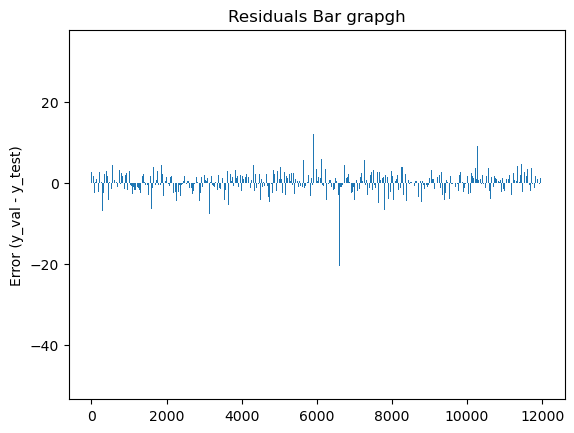

In [963]:
plt.bar(range(len(y_test)),(y_val - y_test)[:,0])
plt.title("Residuals Bar grapgh")
plt.ylabel("Error (y_val - y_test)")
plt.show()

In [964]:
y_test_pred = y_val.detach().numpy()
y_test_actual = y_test.detach().numpy()
# Calculate percentage error
percent_error = np.abs(y_test_pred - y_test_actual) / np.abs(y_test_actual)
# Find indices where error < 25%
good_indices = np.where(percent_error < 0.2)[0]

In [965]:
good_indices

array([    3,     7,     8, ..., 11996, 11998, 11999], shape=(6808,))

Now, here we can see that around half the dataset is giving more than 25% error. We can split the test data set and add the bad predicting dataset to the training data and re train the model with newer training dataset and see again the performance of the test data.

## Saving the model

We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.

In [966]:
# Make sure to save the model only after the training has happened!
if len(losses) == epoch:
    torch.save(model.state_dict(), 'TaxiFareEstimation.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [967]:
model.eval()

Model(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Loading the saved model

In [968]:
model.load_state_dict(torch.load('TaxiFareEstimation.pt', weights_only=True))
model.eval() 

Model(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Predicting from the model

Let's take 5 records from the dataset and assume it to be an unseen data, just to be sure that our model is working fine.

In [969]:
idx = np.random.randint(0,len(cat_test),5)
cat_unseen = cat_test[idx]
cont_unseen = cont_test[idx]

with torch.no_grad():
    y_unseen = model(cat_unseen, cont_unseen)

In [913]:
y_unseen

tensor([[ 5.1601],
        [ 7.1635],
        [10.7592],
        [18.6460],
        [ 9.4728]])